## Heart failure prediction based on the MIMIC-III dataset
This notebook provides a basic code to preprocess the MIMIC-III dataset. It can be used both on Google Colab or in your local machine.
Tables ADMISSIONS and DIAGNOSES were selected and transformed to be further used in the MLP model. The categorical features are converted to numbers and the numerical ones are scaled for inputting in the PyTorch models.

In [1]:
""" # if using google drive, mounting drive for mimic-iii access
from google.colab import drive
drive.mount('/content/drive') """

" # if using google drive, mounting drive for mimic-iii access\nfrom google.colab import drive\ndrive.mount('/content/drive') "

In [2]:
import pandas as pd

# add the path to the files
# if they are in your google drive, it will look something like this:
# /content/drive/MyDrive/Colab Notebooks/mimic-iii-demo/ADMISSIONS.csv

admissions_path = "data\mimic-iii\ADMISSIONS.csv"
diagnoses_path = "data\mimic-iii\DIAGNOSES_ICD.csv"

# loading data
admissions = pd.read_csv(admissions_path)
diagnoses = pd.read_csv(diagnoses_path)

In [3]:
print("\nAdmissions table, containing data about patients admissions:")
admissions.head()


Admissions table, containing data about patients admissions:


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [4]:
print("\nDiagnoses table, containing data about patients' diagnoses based on ICD codes:")
diagnoses.head()


Diagnoses table, containing data about patients' diagnoses based on ICD codes:


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [5]:
# checking for missing values
print("\nMissing values in Admissions:")
print(admissions.isnull().sum())

print("\nMissing values in Diagnoses:")
print(diagnoses.isnull().sum())


Missing values in Admissions:
ROW_ID                      0
SUBJECT_ID                  0
HADM_ID                     0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               53122
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
LANGUAGE                25332
RELIGION                  458
MARITAL_STATUS          10128
ETHNICITY                   0
EDREGTIME               28099
EDOUTTIME               28099
DIAGNOSIS                  25
HOSPITAL_EXPIRE_FLAG        0
HAS_CHARTEVENTS_DATA        0
dtype: int64

Missing values in Diagnoses:
ROW_ID         0
SUBJECT_ID     0
HADM_ID        0
SEQ_NUM       47
ICD9_CODE     47
dtype: int64


In [6]:
# first, remove patients with less than 2 encounters
admissions = admissions.groupby('SUBJECT_ID').filter(lambda x: len(x['HADM_ID']) > 1)

" # first, remove patients with less than 2 encounters\nadmissions = admissions.groupby('SUBJECT_ID').filter(lambda x: len(x['HADM_ID']) > 1) "

In [7]:
admissions.shape

(58976, 19)

In [8]:
filtered_admissions = admissions.groupby('SUBJECT_ID').filter(lambda x: len(x['HADM_ID']) > 1)
unique_patients_with_multiple_visits = filtered_admissions['SUBJECT_ID'].nunique()
print(f"Number of unique patients with multiple visits: {unique_patients_with_multiple_visits}")

Number of unique patients with multiple visits: 7537


In [9]:
unique_subject_ids_count = admissions['SUBJECT_ID'].nunique()
print(f"Total number of patients: {unique_subject_ids_count}")

Total number of patients: 46520


In [10]:
# adding a column with length of stay
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

admissions['length_of_stay'] = (admissions['DISCHTIME'] - admissions['ADMITTIME']).dt.days
print(admissions.head())

   ROW_ID  SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
0      21          22   165315 2196-04-09 12:26:00 2196-04-10 15:54:00   
1      22          23   152223 2153-09-03 07:15:00 2153-09-08 19:10:00   
2      23          23   124321 2157-10-18 19:34:00 2157-10-25 14:00:00   
3      24          24   161859 2139-06-06 16:14:00 2139-06-09 12:48:00   
4      25          25   129635 2160-11-02 02:06:00 2160-11-05 14:55:00   

  DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   

          DISCHARGE_LOCATION INSURANCE LANGUAGE           RELIGION  \
0  DISC-TRAN CANCER/CHLDRN H   Private      NaN       UNOBTAINABLE   
1           HOME HEALTH CARE  Medicare      NaN           CATHOLIC   
2 

In [11]:
# selecting only important attributes
select_adm = ['HADM_ID', 'ADMISSION_TYPE', 'DIAGNOSIS', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'ETHNICITY', 'length_of_stay']

adms = admissions[select_adm]
print(adms.head())
print("\nMissing values in selected Admissions:")
print(adms.isnull().sum())

   HADM_ID ADMISSION_TYPE                                          DIAGNOSIS  \
0   165315      EMERGENCY                            BENZODIAZEPINE OVERDOSE   
1   152223       ELECTIVE  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...   
2   124321      EMERGENCY                                         BRAIN MASS   
3   161859      EMERGENCY                     INTERIOR MYOCARDIAL INFARCTION   
4   129635      EMERGENCY                            ACUTE CORONARY SYNDROME   

          ADMISSION_LOCATION         DISCHARGE_LOCATION INSURANCE ETHNICITY  \
0       EMERGENCY ROOM ADMIT  DISC-TRAN CANCER/CHLDRN H   Private     WHITE   
1  PHYS REFERRAL/NORMAL DELI           HOME HEALTH CARE  Medicare     WHITE   
2  TRANSFER FROM HOSP/EXTRAM           HOME HEALTH CARE  Medicare     WHITE   
3  TRANSFER FROM HOSP/EXTRAM                       HOME   Private     WHITE   
4       EMERGENCY ROOM ADMIT                       HOME   Private     WHITE   

   length_of_stay  
0               1  
1   

In [12]:
# for diagnosis, hospital admission id, and icd-9 codes
# goal: diagnose HF in an admission
diags = diagnoses[['HADM_ID','ICD9_CODE']]
print(diags.head())
print("\nMissing values in selected Diagnoses:")
print(diags.isnull().sum())

   HADM_ID ICD9_CODE
0   172335     40301
1   172335       486
2   172335     58281
3   172335      5855
4   172335      4254

Missing values in selected Diagnoses:
HADM_ID       0
ICD9_CODE    47
dtype: int64


In [13]:
# extracting heart failure diagnosis for binary labels
hf_icd9_codes = ['4250', '4251', '4252', '4253', '4254', '4255', '4257', '4258', '4259', '42983',
                 '42830', '42832', '42840', '42842',
                 '39891', '4280', '4281', '42820', '42822', '4289',
                 '40211', '40291',
                 '40411', '40491',
                 '4168', '4169'
                 ]

# new binary label column indicating heart failure = 1
diags = diagnoses[['HADM_ID', 'ICD9_CODE']].copy()
diags['heart_failure'] = diags['ICD9_CODE'].isin(hf_icd9_codes).astype(int)
diags.head()

,HADM_ID,ICD9_CODE,heart_failure
0,172335,40301,0
1,172335,486,0
2,172335,58281,0
3,172335,5855,0
4,172335,4254,1


In [14]:
diags = diags.groupby('HADM_ID').agg({
    'heart_failure': 'max'
}).reset_index()
diags.head()

,HADM_ID,heart_failure
0,100001,0
1,100003,0
2,100006,0
3,100007,0
4,100009,0


In [15]:
# merging data in a single dataframe
mimic_hf = pd.merge(adms, diags, on=['HADM_ID'], how='inner')
mimic_hf.head()

,HADM_ID,ADMISSION_TYPE,DIAGNOSIS,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,ETHNICITY,length_of_stay,heart_failure
0,165315,EMERGENCY,BENZODIAZEPINE OVERDOSE,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,WHITE,1,0
1,152223,ELECTIVE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,WHITE,5,0
2,124321,EMERGENCY,BRAIN MASS,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,WHITE,6,0
3,161859,EMERGENCY,INTERIOR MYOCARDIAL INFARCTION,TRANSFER FROM HOSP/EXTRAM,HOME,Private,WHITE,2,0
4,129635,EMERGENCY,ACUTE CORONARY SYNDROME,EMERGENCY ROOM ADMIT,HOME,Private,WHITE,3,0


In [16]:
heart_failure_frequencies = mimic_hf['heart_failure'].value_counts()
print(f"\nFrequencies of heart failure (1 = prevalence in an encounter; 0 = non-prevalence):\n{heart_failure_frequencies})")


Frequencies of heart failure (1 = prevalence in an encounter; 0 = non-prevalence):
heart_failure
0    43769
1    15207
Name: count, dtype: int64)


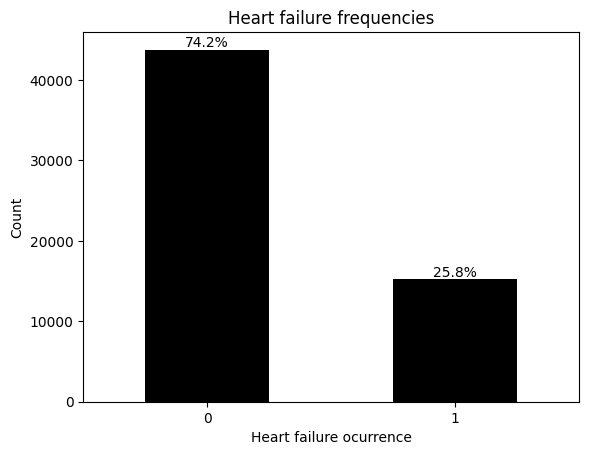

In [17]:
# visualizing the classes
import matplotlib.pyplot as plt

# hf percentages in dataset
total = sum(heart_failure_frequencies)
percentages = (heart_failure_frequencies / total) * 100

# hf value counts
ax = heart_failure_frequencies.plot(kind='bar', color='black')
plt.title('Heart failure frequencies')
plt.xlabel('Heart failure ocurrence')
plt.ylabel('Count')
plt.xticks(rotation=0)

# annotating bars
for idx, rect in enumerate(ax.patches):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height + 5,
            '{:.1f}%'.format(percentages[idx]),
            ha='center', va='bottom', color='black')

plt.show()

In [18]:
# [for optional weighted loss] calculating pos_weight based on heart_failure_frequencies
import torch 

non_hf_frequency = heart_failure_frequencies[0]
hf_frequency = heart_failure_frequencies[1]

pos_weight = torch.tensor([non_hf_frequency / hf_frequency], dtype=torch.float32)
pos_weight

tensor([2.8782])

In [19]:
mimic_hf.shape

(58976, 9)

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# scaling numerical length_of_stay column
mimic_hf['length_of_stay_scaled'] = scaler.fit_transform(mimic_hf[['length_of_stay']])

# replacing the original length_of_stay column with the scaled values
mimic_hf['length_of_stay'] = mimic_hf['length_of_stay_scaled']

# dropping length_of_stay_scaled column
mimic_hf = mimic_hf.drop('length_of_stay_scaled', axis=1)
mimic_hf.head()

,HADM_ID,ADMISSION_TYPE,DIAGNOSIS,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,ETHNICITY,length_of_stay,heart_failure
0,165315,EMERGENCY,BENZODIAZEPINE OVERDOSE,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,WHITE,-0.691485,0
1,152223,ELECTIVE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,WHITE,-0.370263,0
2,124321,EMERGENCY,BRAIN MASS,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,WHITE,-0.289957,0
3,161859,EMERGENCY,INTERIOR MYOCARDIAL INFARCTION,TRANSFER FROM HOSP/EXTRAM,HOME,Private,WHITE,-0.611179,0
4,129635,EMERGENCY,ACUTE CORONARY SYNDROME,EMERGENCY ROOM ADMIT,HOME,Private,WHITE,-0.530874,0


In [1]:
print("\nMissing values in mimic_hf:")
print(mimic_hf.isnull().sum())


Missing values in mimic_hf:


NameError: name 'mimic_hf' is not defined

In [22]:
mimic_hf = mimic_hf.dropna(subset=['DIAGNOSIS']) # dropping entries that have missing values for diagnosis (not that many)

In [23]:
# check for missing values, there shouldnt be any now
print("\nMissing values in mimic_hf:")
print(mimic_hf.isnull().sum())


Missing values in mimic_hf:
HADM_ID               0
ADMISSION_TYPE        0
DIAGNOSIS             0
ADMISSION_LOCATION    0
DISCHARGE_LOCATION    0
INSURANCE             0
ETHNICITY             0
length_of_stay        0
heart_failure         0
dtype: int64


### Feature analysis

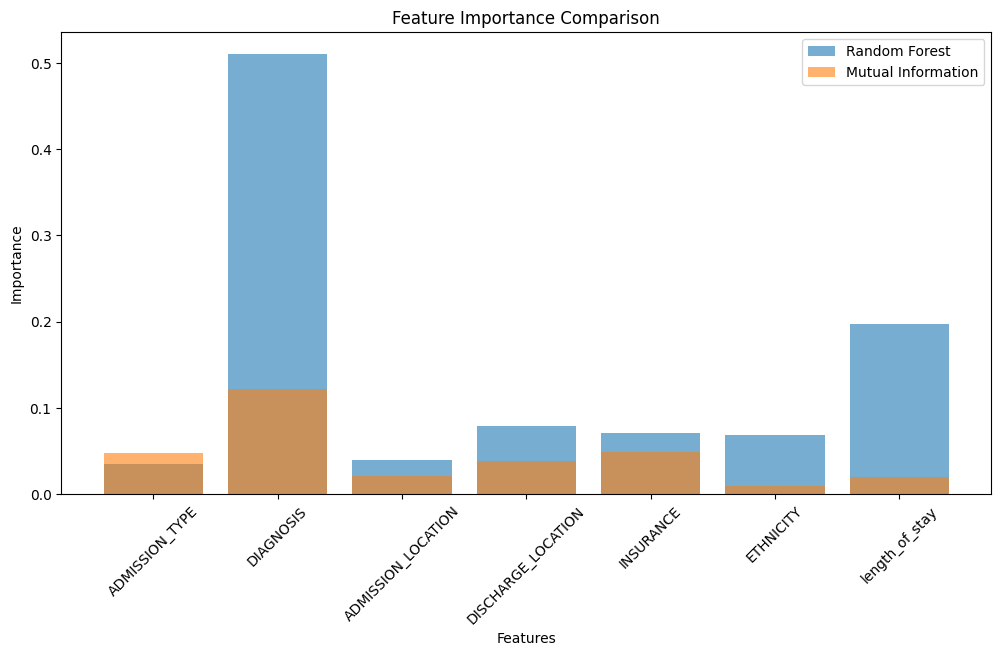

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

# label encoding for categoricals
label_encoders = {}
categorical_columns = ['ADMISSION_TYPE', 'DIAGNOSIS', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'ETHNICITY']

for col in categorical_columns:
    le = LabelEncoder()
    mimic_hf[col] = le.fit_transform(mimic_hf[col])
    label_encoders[col] = le

# feature importance analysis w random forest
X = mimic_hf.drop(columns=['HADM_ID', 'heart_failure'])
y = mimic_hf['heart_failure']

clf = RandomForestClassifier()
clf.fit(X, y)
importances_rf = clf.feature_importances_

# feature importance analysis w mutual information
mi = mutual_info_classif(X, y)

# visualizing feature importance, in terms of heart_failure column
features = X.columns

plt.figure(figsize=(12, 6))
plt.bar(features, importances_rf, label="Random Forest", alpha=0.6)
plt.bar(features, mi, label="Mutual Information", alpha=0.6)
plt.ylabel("Importance")
plt.xlabel("Features")
plt.title("Feature Importance Comparison")
plt.xticks(rotation=45)
plt.legend()
plt.show()


### Preprocessing

In [25]:
# transforming categorical data into one-hot
categorical = ['ADMISSION_TYPE', 'DIAGNOSIS', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'ETHNICITY']
mimic_hf = pd.get_dummies(mimic_hf, columns=categorical)
mimic_hf = mimic_hf * 1
mimic_hf.head()

,HADM_ID,length_of_stay,heart_failure,ADMISSION_TYPE_0,ADMISSION_TYPE_1,ADMISSION_TYPE_2,ADMISSION_TYPE_3,DIAGNOSIS_0,DIAGNOSIS_1,DIAGNOSIS_2,...,ETHNICITY_31,ETHNICITY_32,ETHNICITY_33,ETHNICITY_34,ETHNICITY_35,ETHNICITY_36,ETHNICITY_37,ETHNICITY_38,ETHNICITY_39,ETHNICITY_40
0,165315,-0.691485,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,152223,-0.370263,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,124321,-0.289957,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,161859,-0.611179,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,129635,-0.530874,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [26]:
from sklearn.model_selection import train_test_split
X = mimic_hf.drop(columns=['heart_failure'])
y = mimic_hf['heart_failure']

In [27]:
len(X), len(y) # no. samples

(58951, 58951)

In [28]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of Y: {y[:5]}")

First 5 samples of X:    HADM_ID  length_of_stay  ADMISSION_TYPE_0  ADMISSION_TYPE_1  \
0   165315       -0.691485                 0                 1   
1   152223       -0.370263                 1                 0   
2   124321       -0.289957                 0                 1   
3   161859       -0.611179                 0                 1   
4   129635       -0.530874                 0                 1   

   ADMISSION_TYPE_2  ADMISSION_TYPE_3  DIAGNOSIS_0  DIAGNOSIS_1  DIAGNOSIS_2  \
0                 0                 0            0            0            0   
1                 0                 0            0            0            0   
2                 0                 0            0            0            0   
3                 0                 0            0            0            0   
4                 0                 0            0            0            0   

   DIAGNOSIS_3  ...  ETHNICITY_31  ETHNICITY_32  ETHNICITY_33  ETHNICITY_34  \
0            0  ...  

In [29]:
num_features = X.shape[1]
print(f"Number of features in X: {num_features}")

Number of features in X: 15773


In [30]:
X.shape, y.shape

((58951, 15773), (58951,))

In [31]:
import torch
torch.__version__

'2.0.1+cpu'

In [32]:
""" print(type(X), X.dtype)
print(type(y), X.dtype)
 """

' print(type(X), X.dtype)\nprint(type(y), X.dtype)\n '

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [34]:
len(X_train), len(X_test), len(y_train), len(y_test)


(47160, 11791, 47160, 11791)

## Training

In [35]:
# convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # extra dim for the label

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)  # extra dim for the label


MemoryError: Unable to allocate 5.54 GiB for an array with shape (15773, 47160) and data type float64

In [ ]:
# creating custom dataset
from torch.utils.data import Dataset, DataLoader

class MIMICDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
# creating data loaders
BATCH_SIZE = 32  

train_dataset = MIMICDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = MIMICDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape # 32 batches with 6989 features; 32 batches with 1 feature (label)

(torch.Size([32, 6982]), torch.Size([32, 1]))

In [ ]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
class MLP_MIMIC_V0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_stack = nn.Sequential(
    nn.Linear(in_features=6982, out_features=246),
    nn.ReLU(),
    nn.Linear(in_features=246, out_features=246),
    nn.ReLU(),
    nn.Linear(in_features=246, out_features=1))

  def forward(self, x):
    return self.layer_stack(x)

model_0 = MLP_MIMIC_V0().to(device)

In [ ]:
model_0.state_dict()


OrderedDict([('layer_stack.0.weight',
              tensor([[-2.2571e-03,  4.5418e-03,  2.9593e-03,  ...,  8.0916e-03,
                        5.5424e-03,  2.3908e-04],
                      [ 1.1755e-02, -8.7055e-04, -4.7095e-05,  ...,  6.5226e-03,
                       -3.5955e-03, -3.9453e-03],
                      [ 1.1442e-02,  8.7581e-03, -2.7364e-03,  ..., -6.3023e-03,
                       -1.1028e-02,  8.4560e-03],
                      ...,
                      [ 3.5533e-04,  1.1110e-02, -8.9284e-03,  ...,  1.4281e-03,
                       -3.5735e-03, -9.9069e-03],
                      [ 9.5482e-03, -9.1822e-03,  1.4685e-03,  ...,  1.9274e-03,
                        7.0596e-03, -3.6706e-03],
                      [ 8.2408e-03, -5.1042e-03, -2.5936e-03,  ...,  3.9663e-03,
                       -1.3665e-04,  8.3492e-03]])),
             ('layer_stack.0.bias',
              tensor([ 4.9522e-04, -6.1923e-03,  8.2187e-03, -1.0885e-02, -1.1279e-02,
                       

In [ ]:
loss_fn = nn.BCEWithLogitsLoss() # binary cross entropy loss with built in sigmoid; pos_weight=pos_weight use is optional

optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [ ]:
model_0

MLP_MIMIC_V0(
  (layer_stack): Sequential(
    (0): Linear(in_features=6982, out_features=246, bias=True)
    (1): ReLU()
    (2): Linear(in_features=246, out_features=246, bias=True)
    (3): ReLU()
    (4): Linear(in_features=246, out_features=1, bias=True)
  )
)

In [60]:
# training loop for model_0
torch.manual_seed(22)
torch.cuda.manual_seed(22)
model_0.to(device)

# for tracking model progress
epoch_count_0 = []
train_loss_values_0 = []
train_acc_values_0 = []
test_loss_values_0 = []
test_acc_values_0 = []

# epochs
epochs = 3

for epoch in range(epochs):
    model_0.train()
    running_train_loss = 0.0
    running_train_acc = 0.0
    
    # train loop w dataloaders
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        y_logits = model_0(batch_X).squeeze(1)
        batch_y = batch_y.squeeze(1)
        y_pred = torch.round(torch.sigmoid(y_logits))
        
        train_loss = loss_fn(y_logits, batch_y)
        train_acc = accuracy_fn(y_true=batch_y, y_pred=y_pred)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        running_train_loss += train_loss
        running_train_acc += train_acc
    
    # avg out the loss and accuracy over the entire dataset
    average_train_loss = running_train_loss / len(train_loader)
    average_train_acc = running_train_acc / len(train_loader)

    # test loop w dataloaders
    model_0.eval()
    running_test_loss = 0.0
    running_test_acc = 0.0
    
    with torch.inference_mode():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            test_logits = model_0(batch_X).squeeze(1)
            batch_y = batch_y.squeeze(1)
            test_pred = torch.round(torch.sigmoid(test_logits))
            
            test_loss = loss_fn(test_logits, batch_y)
            test_acc = accuracy_fn(y_true=batch_y, y_pred=test_pred)
            
            running_test_loss += test_loss
            running_test_acc += test_acc
    
    average_test_loss = running_test_loss / len(test_loader)
    average_test_acc = running_test_acc / len(test_loader)

    epoch_count_0.append(epoch)
    train_loss_values_0.append(average_train_loss)
    train_acc_values_0.append(average_train_acc)
    test_loss_values_0.append(average_test_loss)
    test_acc_values_0.append(average_test_acc)

    print(f"Epoch: {epoch + 1} | Train loss: {average_train_loss:.3f} | Train acc: {average_train_acc:.3f} | Test loss: {average_test_loss:.3f} | Test acc: {average_test_acc:.3f}")


Epoch: 1 | Train loss: 8.469 | Train acc: 61.679 | Test loss: 0.661 | Test acc: 63.062
Epoch: 2 | Train loss: 0.665 | Train acc: 61.825 | Test loss: 0.661 | Test acc: 63.062
Epoch: 3 | Train loss: 0.665 | Train acc: 61.822 | Test loss: 0.659 | Test acc: 63.062


In [61]:
class MLP_MIMIC_V1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=6982, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=512, out_features=256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=256, out_features=128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=128, out_features=1)
        )

    def forward(self, x):
        return self.layer_stack(x)

model_1 = MLP_MIMIC_V1().to(device)


In [62]:
loss_fn = nn.BCEWithLogitsLoss() # binary cross entropy loss with built in sigmoid
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)

# training loop for model_1
torch.manual_seed(22)
torch.cuda.manual_seed(22)
model_1.to(device)

# for tracking model progress
epoch_count_1 = []
train_loss_values_1 = []
train_acc_values_1 = []
test_loss_values_1 = []
test_acc_values_1 = []

# epochs
epochs = 3

for epoch in range(epochs):
    model_1.train()
    running_train_loss = 0.0
    running_train_acc = 0.0
    
    # train loop w dataloaders
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        y_logits = model_1(batch_X).squeeze(1)
        batch_y = batch_y.squeeze(1)
        y_pred = torch.round(torch.sigmoid(y_logits))
        
        train_loss = loss_fn(y_logits, batch_y)
        train_acc = accuracy_fn(y_true=batch_y, y_pred=y_pred)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        running_train_loss += train_loss
        running_train_acc += train_acc
    
    # avg out the loss and accuracy over the entire dataset
    average_train_loss = running_train_loss / len(train_loader)
    average_train_acc = running_train_acc / len(train_loader)

    # test loop w dataloaders
    model_1.eval()
    running_test_loss = 0.0
    running_test_acc = 0.0
    
    with torch.inference_mode():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            test_logits = model_1(batch_X).squeeze(1)
            batch_y = batch_y.squeeze(1)
            test_pred = torch.round(torch.sigmoid(test_logits))
            
            test_loss = loss_fn(test_logits, batch_y)
            test_acc = accuracy_fn(y_true=batch_y, y_pred=test_pred)
            
            running_test_loss += test_loss
            running_test_acc += test_acc
    
    average_test_loss = running_test_loss / len(test_loader)
    average_test_acc = running_test_acc / len(test_loader)

    epoch_count_1.append(epoch)
    train_loss_values_1.append(average_train_loss)
    train_acc_values_1.append(average_train_acc)
    test_loss_values_1.append(average_test_loss)
    test_acc_values_1.append(average_test_acc)

    print(f"Epoch: {epoch + 1} | Train loss: {average_train_loss:.3f} | Train acc: {average_train_acc:.3f} | Test loss: {average_test_loss:.3f} | Test acc: {average_test_acc:.3f}")


Epoch: 1 | Train loss: 0.679 | Train acc: 60.077 | Test loss: 0.661 | Test acc: 63.062
Epoch: 2 | Train loss: 0.668 | Train acc: 61.593 | Test loss: 0.659 | Test acc: 63.062
Epoch: 3 | Train loss: 0.666 | Train acc: 61.757 | Test loss: 0.659 | Test acc: 63.062


## Model evaluations

### Model 0

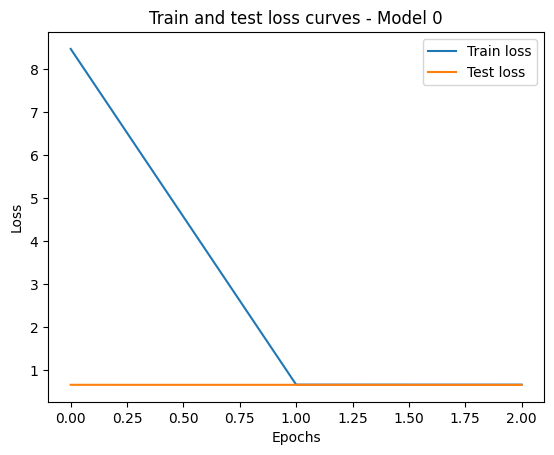

In [64]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(epoch_count_0, np.array(torch.tensor(train_loss_values_0).numpy()), label="Train loss")
plt.plot(epoch_count_0, np.array(torch.tensor(test_loss_values_0).numpy()), label="Test loss")
plt.title("Train and test loss - Model 0")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

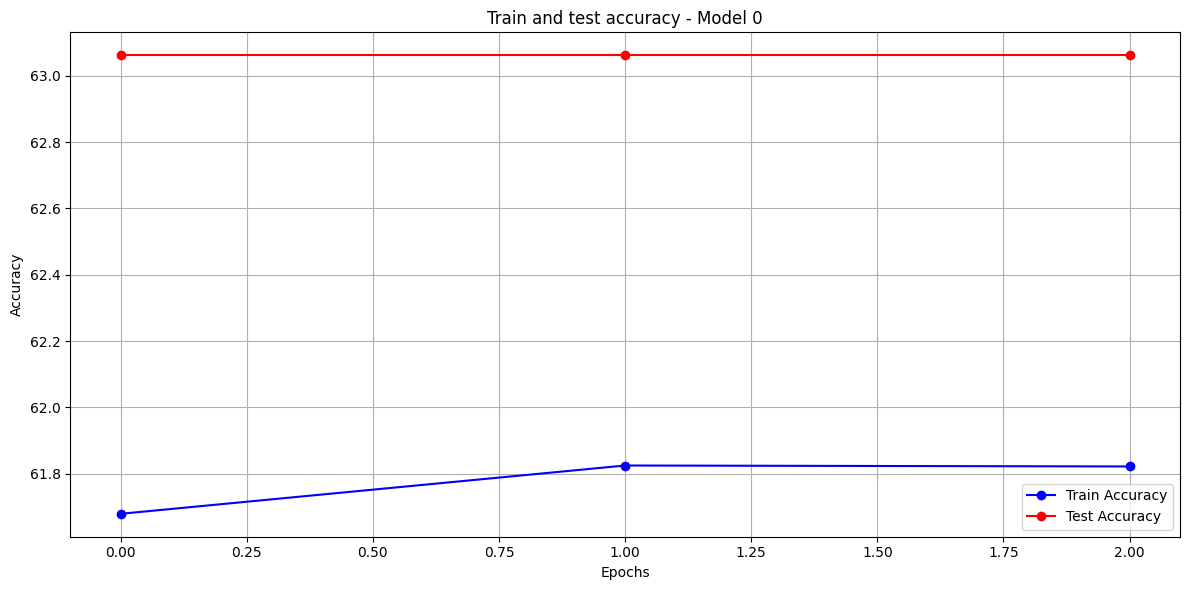

In [66]:
plt.figure(figsize=(12, 6))

plt.plot(epoch_count_0, train_acc_values_0, '-o', label='Train Accuracy', color='blue')
plt.plot(epoch_count_0, test_acc_values_0, '-o', label='Test Accuracy', color='red')

plt.title('Train and test accuracy - Model 0')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

AUC for MLP Model 0: 0.5000


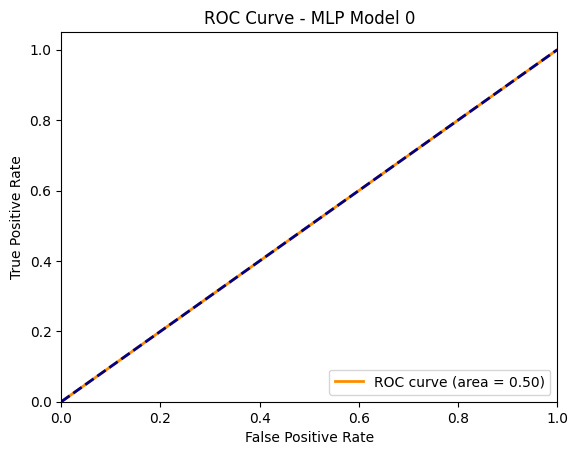

In [69]:
from sklearn.metrics import roc_curve, auc

all_test_probabilities = []
all_true_labels = []

# iterating w test loader
with torch.inference_mode():
    for batch_X, batch_y in test_loader:
        # device agnostic 
        batch_X = batch_X.cuda() if next(model_0.parameters()).is_cuda else batch_X
        batch_y = batch_y.cuda() if next(model_0.parameters()).is_cuda else batch_y
        
        test_logits = model_0(batch_X).squeeze()
        test_probabilities = torch.sigmoid(test_logits).cpu().numpy()
        
        all_test_probabilities.extend(test_probabilities)
        all_true_labels.extend(batch_y.cpu().numpy())

# false positive and true positive rates and thresholds
fpr, tpr, thresholds = roc_curve(all_true_labels, all_test_probabilities)

# calculate auc
roc_auc = auc(fpr, tpr)

# print auc
print(f"AUC for MLP Model 0: {roc_auc:.4f}")

# plot roc and auc
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # random classifier diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP Model 0')
plt.legend(loc="lower right")
plt.show()


### Model 1

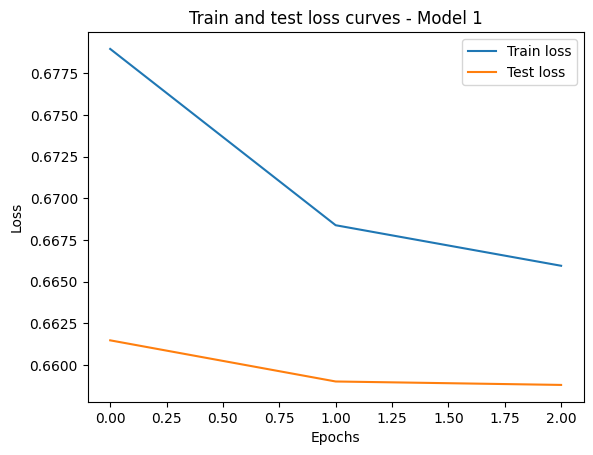

In [70]:
plt.plot(epoch_count_1, np.array(torch.tensor(train_loss_values_1).numpy()), label="Train loss")
plt.plot(epoch_count_1, np.array(torch.tensor(test_loss_values_1).numpy()), label="Test loss")
plt.title("Train and test loss - Model 1")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

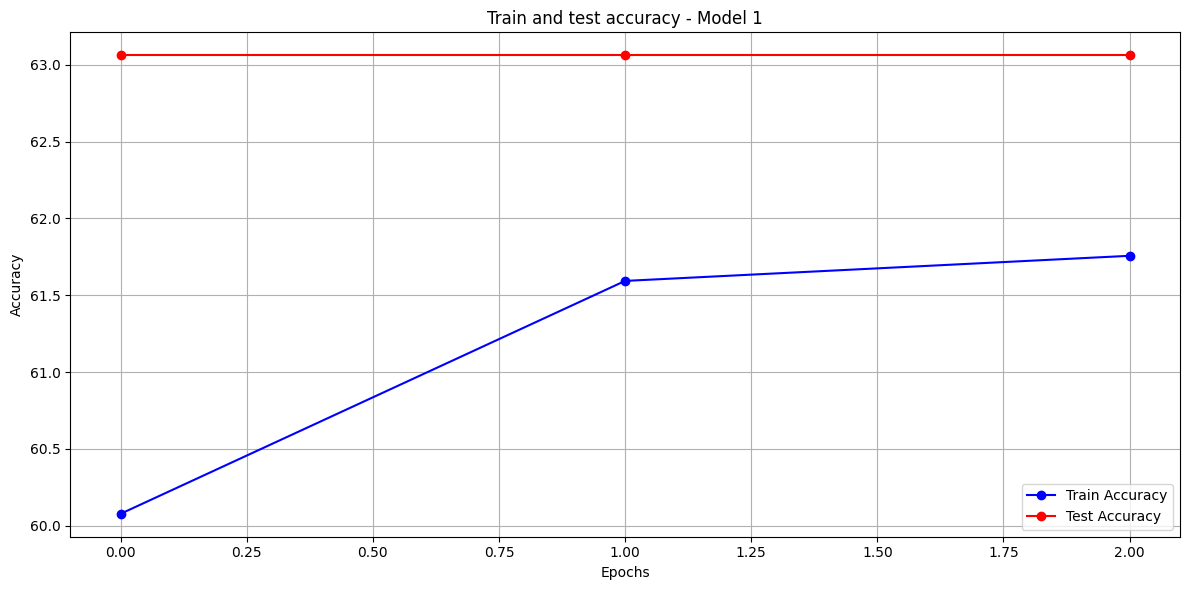

In [71]:
plt.figure(figsize=(12, 6))

plt.plot(epoch_count_1, train_acc_values_1, '-o', label='Train Accuracy', color='blue')
plt.plot(epoch_count_1, test_acc_values_1, '-o', label='Test Accuracy', color='red')

plt.title('Train and test accuracy - Model 1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

AUC for MLP Model 1: 0.4864


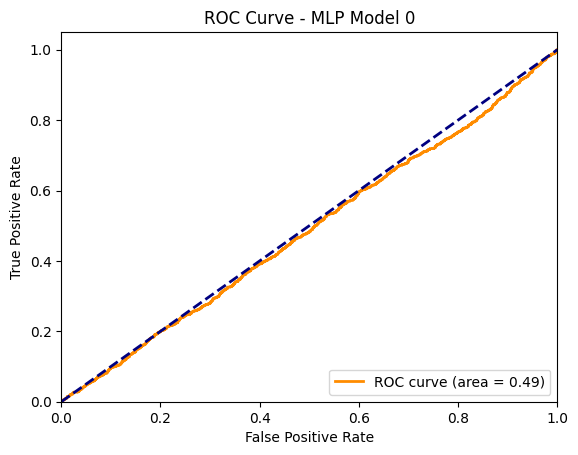

In [72]:
all_test_probabilities = []
all_true_labels = []

# iterating w test loader
with torch.inference_mode():
    for batch_X, batch_y in test_loader:
        # device agnostic 
        batch_X = batch_X.cuda() if next(model_1.parameters()).is_cuda else batch_X
        batch_y = batch_y.cuda() if next(model_1.parameters()).is_cuda else batch_y
        
        test_logits = model_1(batch_X).squeeze()
        test_probabilities = torch.sigmoid(test_logits).cpu().numpy()
        
        all_test_probabilities.extend(test_probabilities)
        all_true_labels.extend(batch_y.cpu().numpy())

# false positive and true positive rates and thresholds
fpr, tpr, thresholds = roc_curve(all_true_labels, all_test_probabilities)

# calculate auc
roc_auc = auc(fpr, tpr)

# print auc
print(f"AUC for MLP Model 1: {roc_auc:.4f}")

# plot roc and auc
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # random classifier diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP Model 1')
plt.legend(loc="lower right")
plt.show()


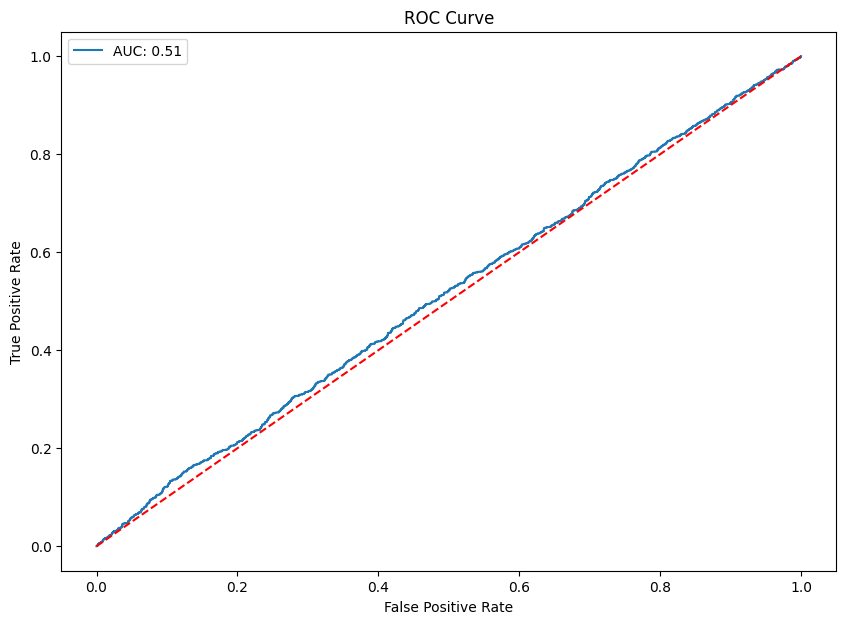

Accuracy: 0.63
AUC: 0.51


In [74]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train.ravel())

# predict probs
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# compute accuracy
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test.ravel(), y_pred)

# compute auc
auc = roc_auc_score(y_test.ravel(), y_pred_prob)

# compute and plot roc curve
fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred_prob)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {auc:.2f}")
